## Introduction

AirSeaFluxCode is developed to provide an easy and accessible way to calculate turbulent surface fluxes (TSFs) from a small number of bulk variables and for a viariety of bulk algorithms. 

By running AirSeaFluxCode you can compare different bulk algorithms and to also investigate the effect choices within the implementation of each parameterisation have on the TSFs estimates. 


### Getting started

Let's first import the basic python packages we will need for reading in our input data, to perform basic statistics  and plotting

In [1]:
# first import all packages you might need
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd

### Exchange coefficients
We can implement a function to calculate the exchange coefficients and momentum roughness length given the method and the 10 metre neutral wind speed (u10n). Note that these are the same functions included in flux_subs.py (cdn_calc, ctcqn_calc, cdn_from roughness) that are called in AirSeaFluxCode, just adjusted to run with dummy input data generated in the next step.

In [2]:
kappa = 0.4 # von Karman's constant
def blk_neutral(meth, u10n):
    ub = np.maximum(u10n, 0.1)
    # first guess
    cdn = 8.575e-5*ub + 0.657e-3
    ctn, cqn = np.zeros(u10n.shape), np.zeros(u10n.shape)
    zo, zc = np.zeros(u10n.shape), np.zeros(u10n.shape)
    zs = np.zeros(u10n.shape)
    if (meth == "S80"):
        cdn = (0.61+0.063*u10n)*0.001
    elif (meth == "LP82" or meth == "LP82(zol<=0)" or meth == "LP82(zol>0)"):
        cdn = np.where(u10n < 4, 1.14*0.001,
                       np.where((u10n < 11) & (u10n >= 4), 1.2*0.001,
                                (0.49+0.065*u10n)*0.001))
    elif (meth == "YT96"):
        # convert usr in eq. 21 to cdn to expand for low wind speeds
        cdn = np.power((0.10038+u10n*2.17e-3+np.power(u10n, 2)*2.78e-3 -
                        np.power(u10n, 3)*4.4e-5)/u10n, 2)
    elif (meth == "LY04" or meth == "LY04(zol<=0)" or meth == "LY04(zol>0)"):
        cdn = np.where(u10n > 0.5, (0.142+2.7/u10n+u10n/13.09 -
                                    3.14807e-10*np.power(u10n, 6))*1e-3,
                       (0.142+2.7/0.5+0.5/13.09 -
                        3.14807e-10*np.power(0.5, 6))*1e-3)
        cdn = np.where(u10n > 33, 2.34e-3, np.copy(cdn))
        cdn = np.maximum(np.copy(cdn), 0.1e-3)
    else:
        for it in range(50):
            usr = ub*np.sqrt(cdn)
            if (meth == "S88"):
                # Charnock roughness length (eq. 4 in Smith 88)
                zc = 0.011*np.power(usr, 2)/9.8
                #  smooth surface roughness length (eq. 6 in Smith 88)
                zs = 0.11*1.5e-5/usr
                zo = zc + zs  #  eq. 7 & 8 in Smith 88
            elif (meth == "UA"):
                # valid for 0<u<18m/s # Zeng et al. 1998 (24)
                zo = 0.013*np.power(usr, 2)/9.8+0.11*1.5e-5/usr
            elif (meth == "C30"):
                a = 0.011*np.ones(u10n.shape)
                a = np.where(u10n > 10, 0.011+(u10n-10)*(0.018-0.011)/(18-10),
                             np.where(u10n > 18, 0.018, a))
                zo = a*np.power(usr, 2)/9.8+0.11*1.5e-5/usr
            elif (meth == "C35"):
                zo = (0.11*1.5e-5/usr +
                      np.minimum(0.0017*19-0.0050, 0.0017*u10n-0.0050) *
                      np.power(usr, 2)/9.8)
            elif ((meth == "ecmwf" or meth == "Beljaars")):
                # eq. (3.26) p.38 over sea IFS Documentation cy46r1
                zo = 0.018*np.power(usr, 2)/9.8+0.11*1.5e-5/usr
            else:
                print("method unknown")
        cdn = np.power(kappa/np.log(10/zo), 2)

    if (meth == "S80" or meth == "S88" or meth == "YT96"):
        cqn = np.ones(u10n.shape)*1.20*0.001  # from S88
        ctn = np.ones(u10n.shape)*1.00*0.001
    elif (meth == "LP82(zol<=0)"):
        cqn = np.ones(u10n.shape)*1.15*0.001
        ctn = np.ones(u10n.shape)*1.13*0.001
    elif (meth == "LP82(zol>0)"):
        cqn = np.ones(u10n.shape)*0.001
        ctn = np.ones(u10n.shape)*0.66*0.001
    elif (meth == "LY04(zol>0)"):
        cqn = np.maximum(34.6*0.001*np.sqrt(cdn), 0.1e-3)
        ctn = np.maximum(18*0.001*np.sqrt(cdn), 0.1e-3)
    elif (meth == "LY04(zol<=0)"):
        cqn = np.maximum(34.6*0.001*np.sqrt(cdn), 0.1e-3)
        ctn = np.maximum(32.7*0.001*np.sqrt(cdn), 0.1e-3)
    elif (meth == "UA"):
        usr = np.sqrt(cdn*np.power(u10n, 2))
        # Zeng et al. 1998 (25)
        usr = np.sqrt(cdn*np.power(u10n, 2))
        rr = usr*zo/1.5e-5
        zoq = zo/np.exp(2.67*np.power(rr, 1/4)-2.57)
        zot = np.copy(zoq)
        cqn = np.power(kappa, 2)/(np.log(10/zo)*np.log(10/zoq))
        ctn = np.power(kappa, 2)/(np.log(10/zo)*np.log(10/zoq))
    elif (meth == "C30"):
        usr = np.sqrt(cdn*np.power(u10n, 2))
        rr = zo*usr/1.5e-5
        zoq = np.minimum(5e-5/np.power(rr, 0.6), 1.15e-4)  # moisture roughness
        zot = np.copy(zoq)  # temperature roughness
        cqn = np.power(kappa, 2)/np.log(10/zo)/np.log(10/zoq)
        ctn = np.power(kappa, 2)/np.log(10/zo)/np.log(10/zot)
    elif (meth == "C35"):
        usr = np.sqrt(cdn*np.power(u10n, 2))
        rr = zo*usr/1.5e-5
        zoq = np.minimum(5.8e-5/np.power(rr, 0.72), 1.6e-4) # moisture roughness
        zot = np.copy(zoq)  # temperature roughness
        cqn = np.power(kappa, 2)/np.log(10/zo)/np.log(10/zoq)
        ctn = np.power(kappa, 2)/np.log(10/zo)/np.log(10/zot)

    elif (meth == "ecmwf" or meth == "Beljaars"):
        # eq. (3.26) p.38 over sea IFS Documentation cy46r1
        usr = np.sqrt(cdn*np.power(u10n, 2))
        zot = 0.40*1.5e-5/usr
        zoq = 0.62*1.5e-5/usr
        cqn = kappa**2/np.log(10/zo)/np.log(10/zoq)
        ctn = kappa**2/np.log(10/zo)/np.log(10/zot)
    else:
        print("unknown method ctcqn: "+meth)
    return cdn, ctn, cqn, zo


Then, generate "dummy" values for u10n to use as input to blk_neutral.

In [3]:
u10n = np.zeros(1201)
for jw in range(2, 1201):
    dw = 0.25*(60/(1201-1))
    if (u10n[jw-1] >= 5):
        dw = 60/(1201-1)
    if (u10n[jw-1] >= 30):
        dw = 2*(60/(1201-1))
    u10n[jw] = u10n[jw-1]+dw

Now, you can run blk_neutral for any method ("S80", "S88", "LP82(zol<=0)", "LP82(zol>0)", "YT96", "UA", "LY04(zol<=0)", "LY04(zol>0)", "C30", "C35", "C40", "ecmwf", "Beljaars") and with the "dummy" u10n we generated.
Let's try it for UA and plot the result.

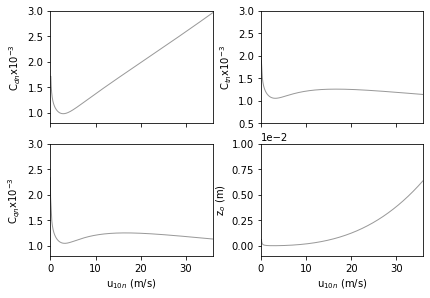

In [4]:
cdn, ctn, cqn, zo = blk_neutral("UA", u10n)
fig, ax = plt.subplots(2, 2, sharex=True, sharey=False)
fig.tight_layout()
# fig.subplots_adjust(wspace=0.5)
ax[0, 0].plot(u10n, cdn*1e3, "-", color="grey", linewidth=1, alpha = 0.8)
ax[0, 1].plot(u10n, ctn*1e3, "-", color="grey", linewidth=1, alpha = 0.8)
ax[1, 0].plot(u10n, cqn*1e3, "-", color="grey", linewidth=1, alpha = 0.8)
ax[1, 1].plot(u10n, zo, "-", color="grey", linewidth=1, alpha = 0.8)
ax[0, 0].set_ylabel('C$_{dn}$x10$^{-3}$')
ax[0, 0].set_ylim([0.8, 3])
ax[0, 0].set_xlim([0, 36])
ax[0, 1].set_ylabel('C$_{tn}$x10$^{-3}$')
ax[0, 1].set_ylim([0.5, 3])
ax[0, 1].set_xlim([0, 36])
ax[1, 0].set_ylabel('C$_{qn}$x10$^{-3}$')
ax[1, 0].set_ylim([0.8, 3])
ax[1, 0].set_xlim([0, 36])
ax[1, 1].set_ylabel('z$_{o}$ (m)')
ax[1, 1].set_ylim([-0.001, 0.01])
ax[1, 1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1, 1].set_xlim([0, 36])
ax[1, 0].set_xlabel('u$_{10n}$ (m/s)')
ax[1, 1].set_xlabel('u$_{10n}$ (m/s)')
plt.show()

### AirSeaFluxCode examples

AirSeaFluxCode is set up to run in its default setting with a minimum number of input variables, namely wind speed; air temperature; and sea surface temperature. Let's load the code, import some real data composed for testing it (Research vessel data) and run AirSeaFluxCode with default settings (latitude set to 45&deg;N, relative humidity 80%, atmospheric pressure 1013hPa, sensor height 18m, output height 10m, cool skin/warm layer corrections turned off, bulk algorithm Smith 1988, gustiness on, saturation vapour pressure following Buck, 2012, tolerance limits set for flux estimates and height adjusted variables (['all', 0.01, 0.01, 1e-05, 1e-3, 0.1, 0.1]), number of iterations are ten, non converged points are set to missing and Monin-Obukhov stability length is calculated following the ECMWF implementation.

In [5]:
from AirSeaFluxCode import AirSeaFluxCode

In [6]:
inDt = pd.read_csv("data_all.csv")
date = np.asarray(inDt["Date"])
lon = np.asarray(inDt["Longitude"])
lat = np.asarray(inDt["Latitude"])
spd = np.asarray(inDt["Wind speed"])
t = np.asarray(inDt["Air temperature"])
sst = np.asarray(inDt["SST"])
rh = np.asarray(inDt["RH"])
p = np.asarray(inDt["P"])
sw = np.asarray(inDt["Rs"])
hu = np.asarray(inDt["zu"])
ht = np.asarray(inDt["zt"])
hin = np.array([hu, ht, ht])
del hu, ht, inDt
# run AirSeaFluxCode
res = AirSeaFluxCode(spd, t, sst)
flg = res["flag"]

res is the output of AirSeaFluxCode which is a dataFrame with keys: "tau", "shf", "lhf", "L", "cd", "cdn", "ct", "ctn", "cq", "cqn", "tsrv", "tsr", "qsr", "usr", "psim", "psit","psiq", "u10n", "t10n", "tv10n", "q10n", "zo", "zot", "zoq", "uref", "tref", "qref", "iteration", "dter", "dqer", "dtwl", "qair", "qsea", "Rl", "Rs", "Rnl", "ug", "Rib", "rh". Let's plot the flux estimates.

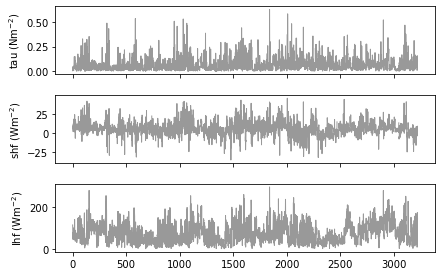

In [7]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey=False)
fig.tight_layout()
ax[0].plot(res["tau"], "-", color="grey", linewidth=1, alpha = 0.8)
ax[1].plot(res["shf"], "-", color="grey", linewidth=1, alpha = 0.8)
ax[2].plot(res["lhf"], "-", color="grey", linewidth=1, alpha = 0.8)
ax[0].set_ylabel('tau (Nm$^{-2}$)')
ax[1].set_ylabel('shf (Wm$^{-2}$)')
ax[2].set_ylabel('lhf (Wm$^{-2}$)')
plt.show()

Now we can use the real input we have for latitude, sensor heights, relative humidity, air pressure and shortwave radiation. We will also use the cool skin correction option for bulk algorithm Coare 3.5 (C35) and run 30 iterations.

In [8]:
res = AirSeaFluxCode(spd, t, sst, lat=lat, hin=hin, P=p, hum=['rh', rh], Rs=sw, cskin=1, skin="C35", meth="C35", n=30)

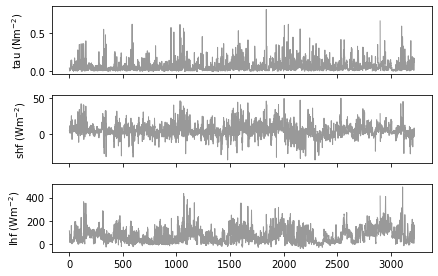

In [9]:
# plot the results
fig, ax = plt.subplots(3, 1, sharex=True, sharey=False)
fig.tight_layout()
ax[0].plot(res["tau"], "-", color="grey", linewidth=1, alpha = 0.8)
ax[1].plot(res["shf"], "-", color="grey", linewidth=1, alpha = 0.8)
ax[2].plot(res["lhf"], "-", color="grey", linewidth=1, alpha = 0.8)
ax[0].set_ylabel('tau (Nm$^{-2}$)')
ax[1].set_ylabel('shf (Wm$^{-2}$)')
ax[2].set_ylabel('lhf (Wm$^{-2}$)')
plt.show()